In [1]:
import pandas as pd
import numpy as np

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage
import scipy.cluster.hierarchy as sch 
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy as clust

from sklearn import preprocessing as prep
from sklearn.preprocessing import binarize
from sklearn.model_selection import train_test_split
from sklearn import metrics, svm
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, RANSACRegressor
from sklearn.metrics import accuracy_score, mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import RidgeClassifierCV
from sklearn.cluster import AgglomerativeClustering as ac
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering


from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyo
import plotly.figure_factory as ff
import plotly.io as pio

import seaborn as sns
import kaleido

import statsmodels.api
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Cereal Analysis

Our aim is to explore this data to futher understand what this data wants to tell us.

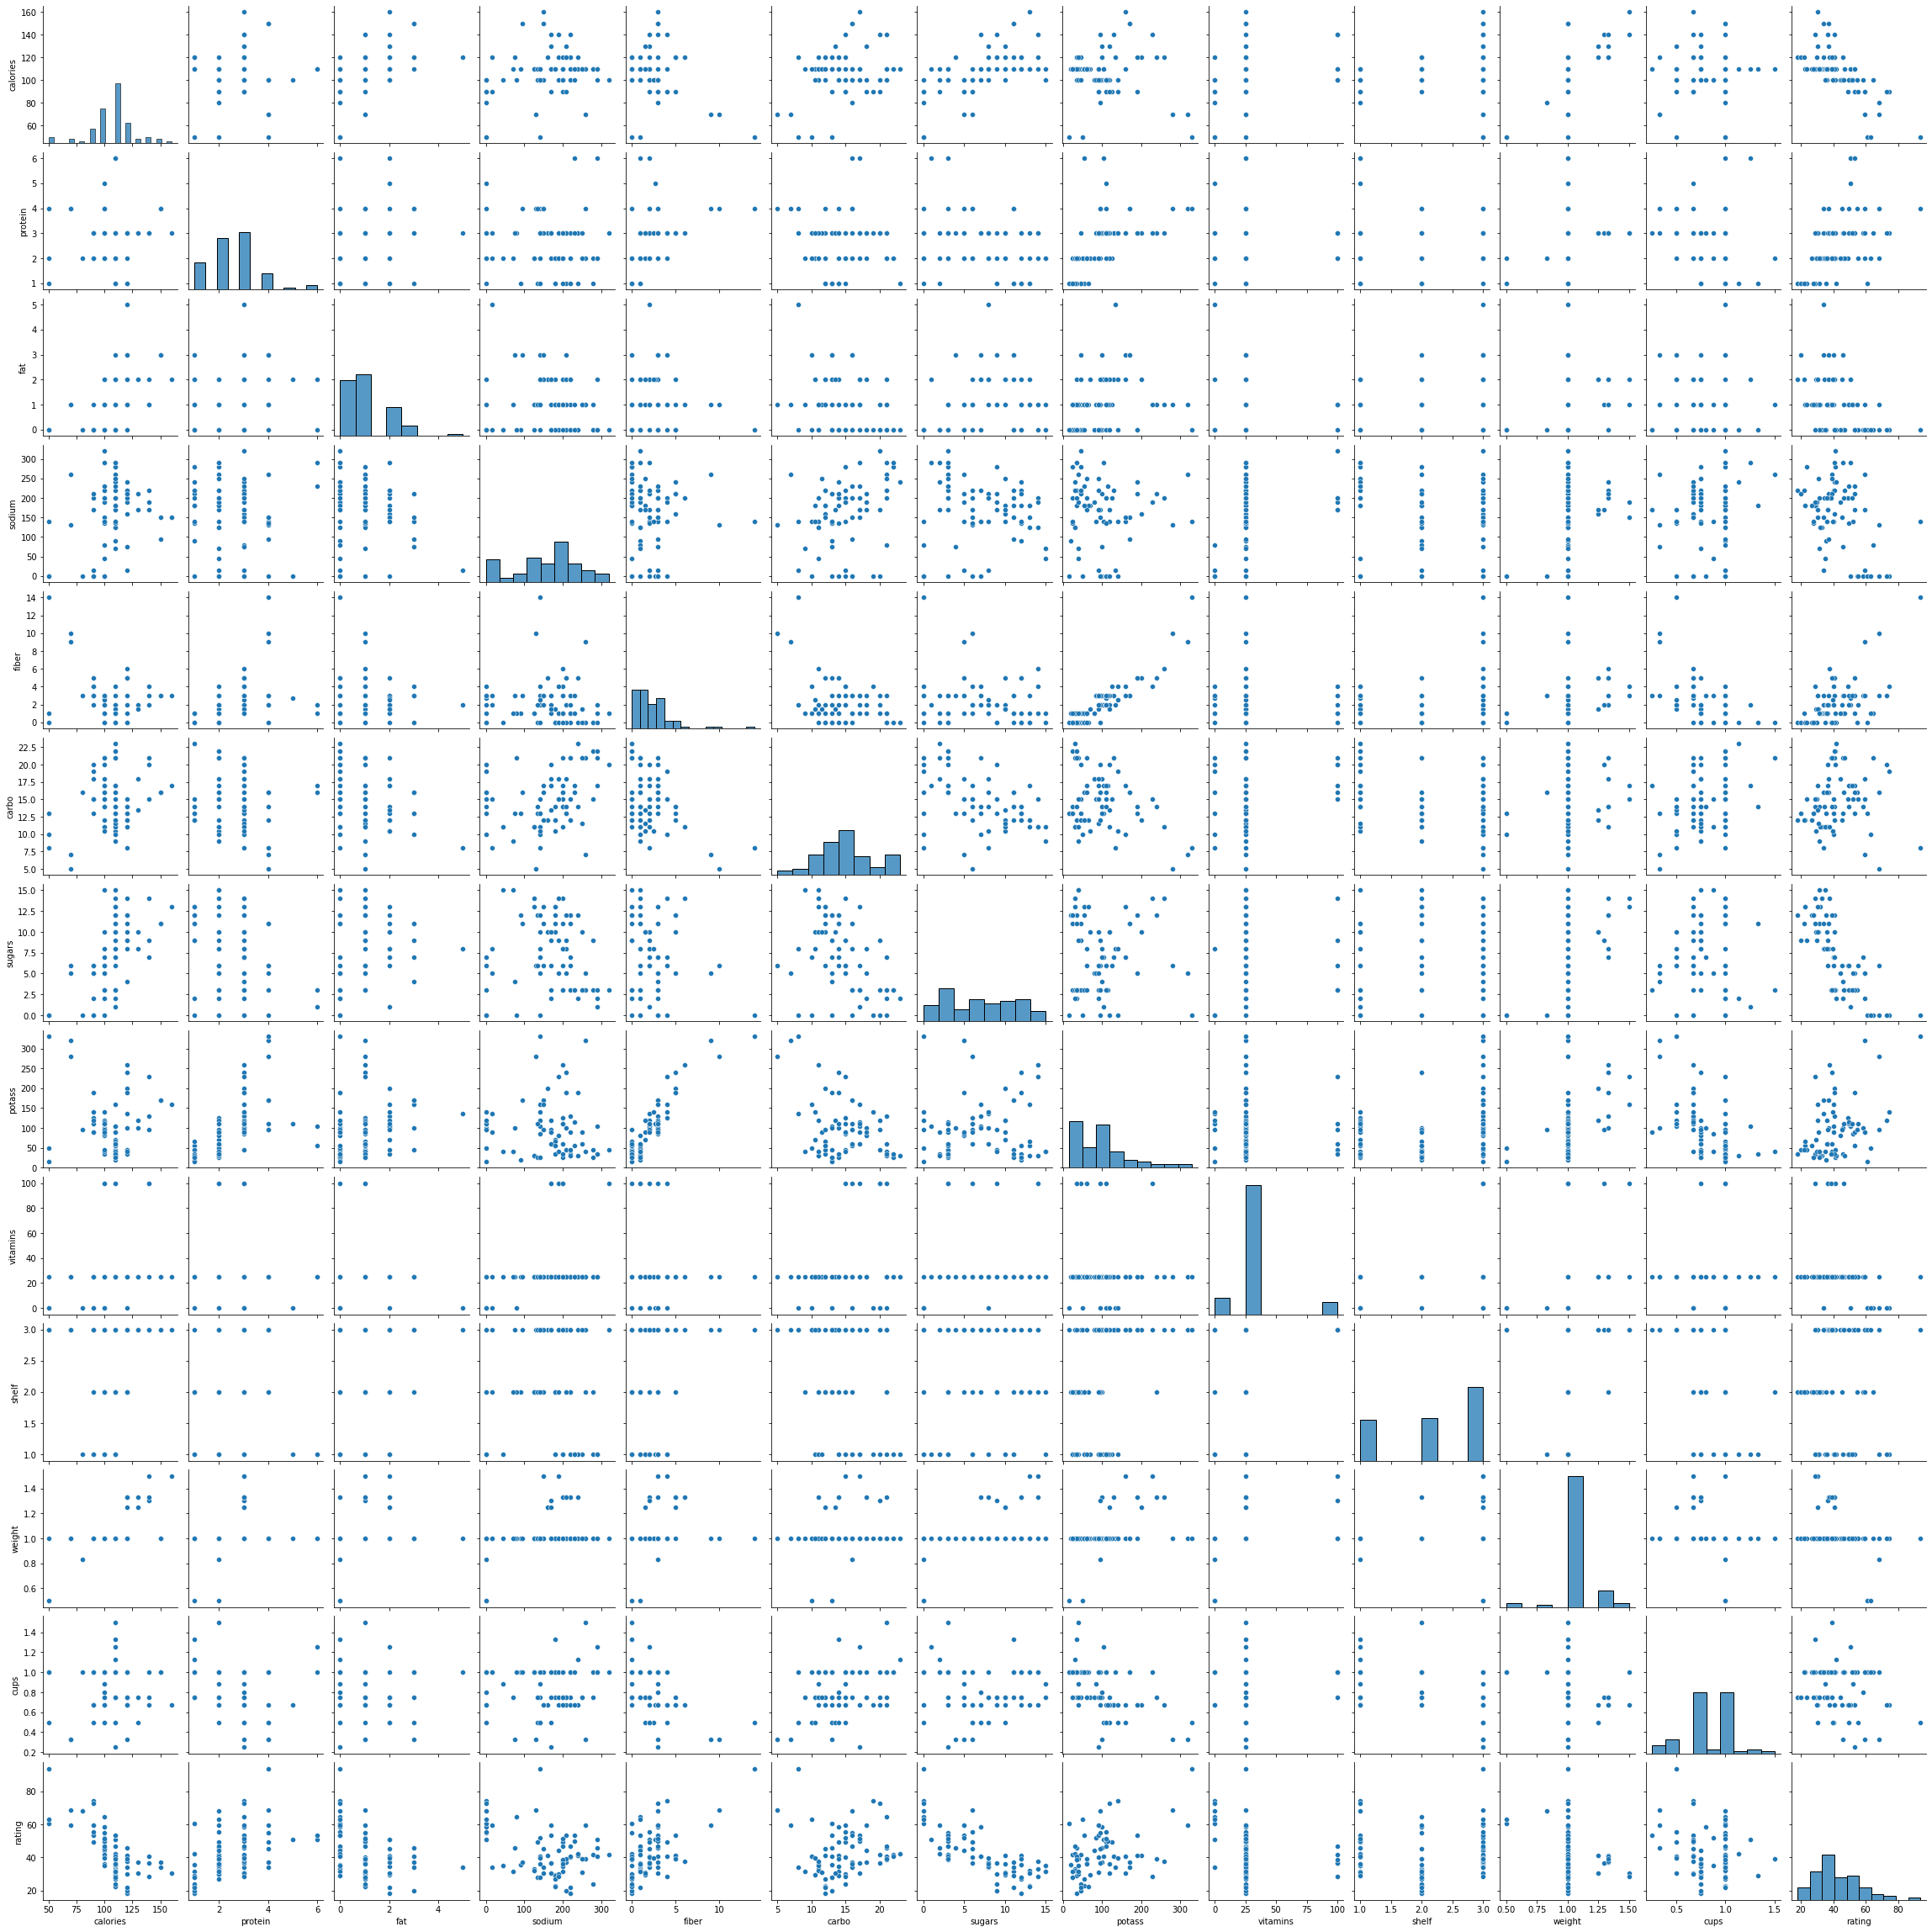

In [2]:
# Read data
CerealsData = pd.read_csv("Cereals.csv") 
# Select numerical data
NumericData = CerealsData.select_dtypes(include='number')
sns.pairplot(CerealsData)

* Sodium has the largest variability, and high variance not only can cause overfiiting in model,but also can decrease the statistical power, broadening C.I., so we should normalize this data.
* Protien, fat, fiber, potass, vitamins, shelf, cups, and rating are all skewed

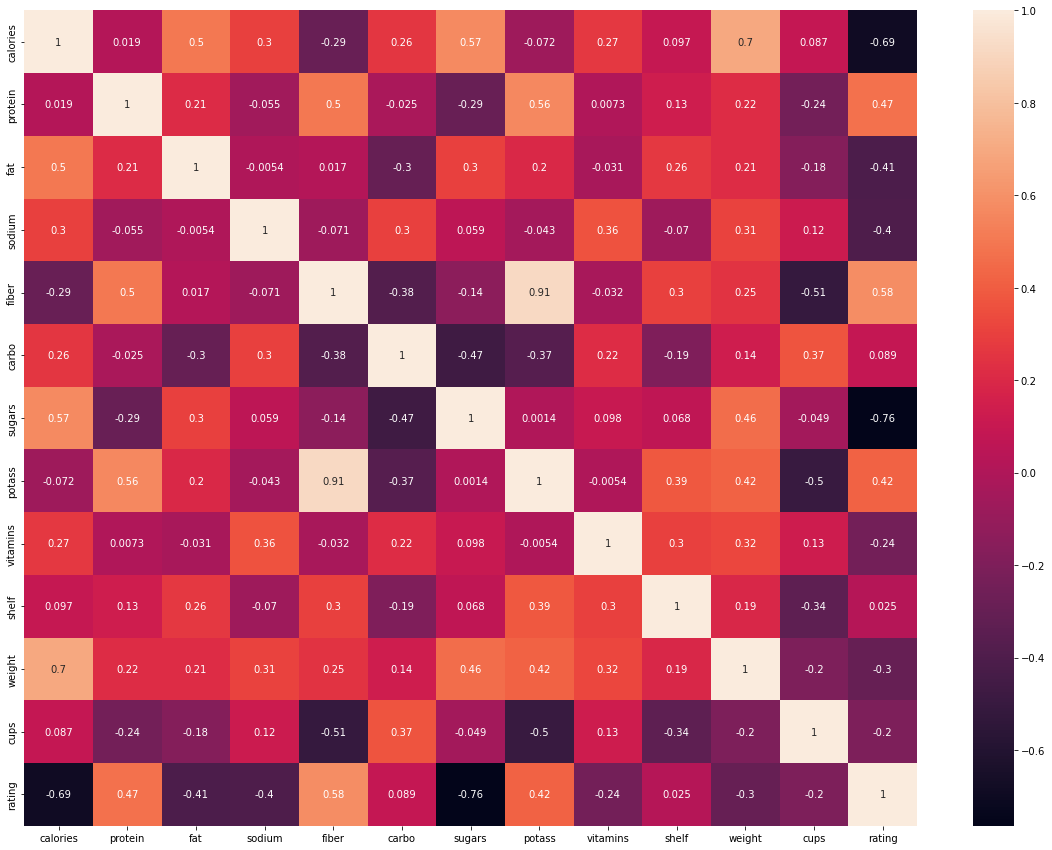

In [3]:
plt.figure(figsize=(20, 15))
sns.heatmap(NumericData.corr(),annot=True)
plt.show('png')

* As the heatmap shown above, calories, sugars, fat, sodium can lead a lower health rating, and portein, fiberm, and potass all have a positive relationship with rating. An interesting fact is vitamins seems to be good supplments, but they have a negative impact on health rating.

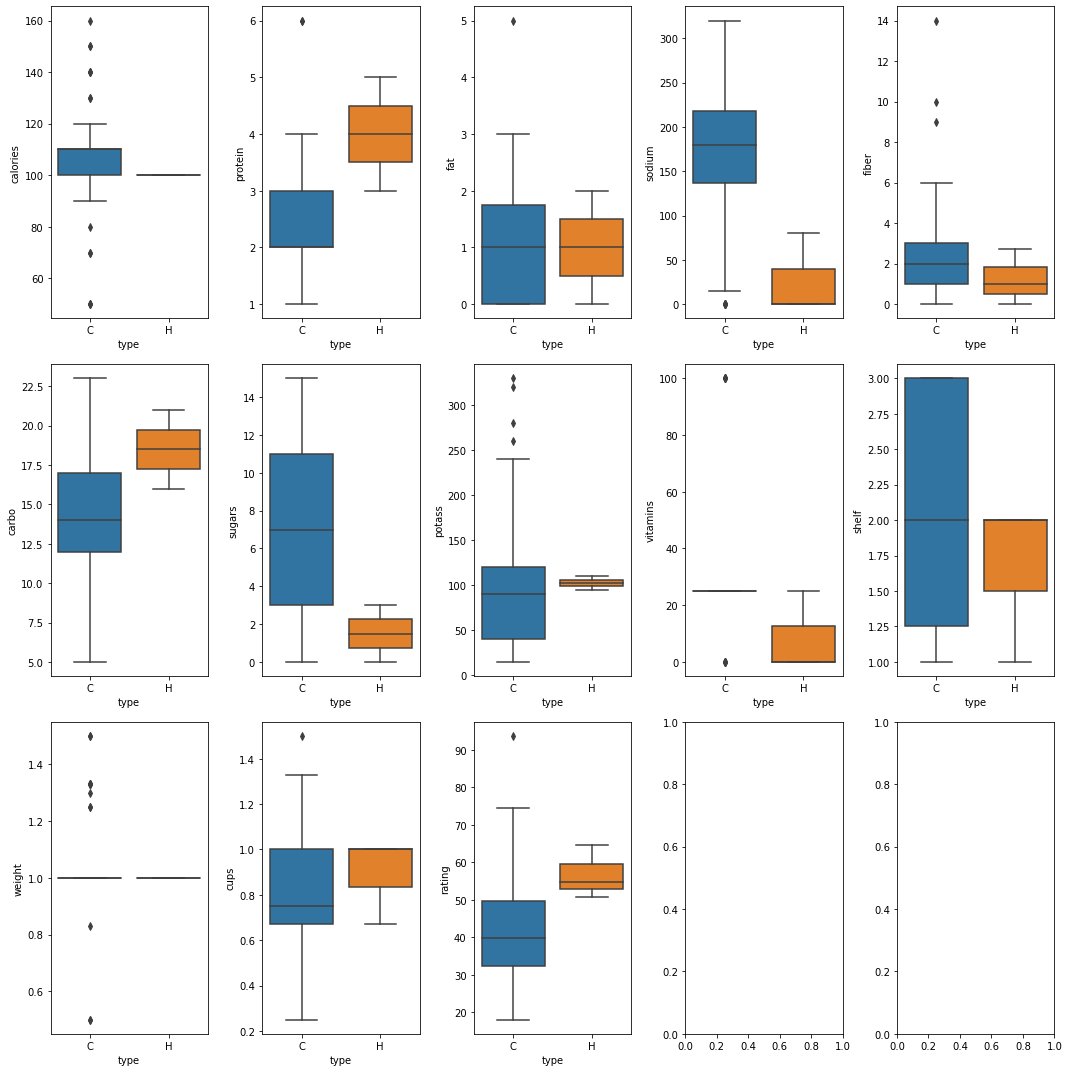

In [4]:
names = NumericData.columns
ncols = len(names)
fig, axes = plt.subplots(nrows=3, ncols=5,figsize=(15,15))
for name, ax in zip(names, axes.flatten()):
    sns.boxplot(y=name, x= CerealsData['type'], data=CerealsData, orient='v', ax=ax)
    
plt.tight_layout()

* As the boxplots shown above, hot cereals contain higher portien and carbon, and with lower sugar and sodium, so if our aim is to target those customers who like to have healthy diet, we should promote hot cereals to them.

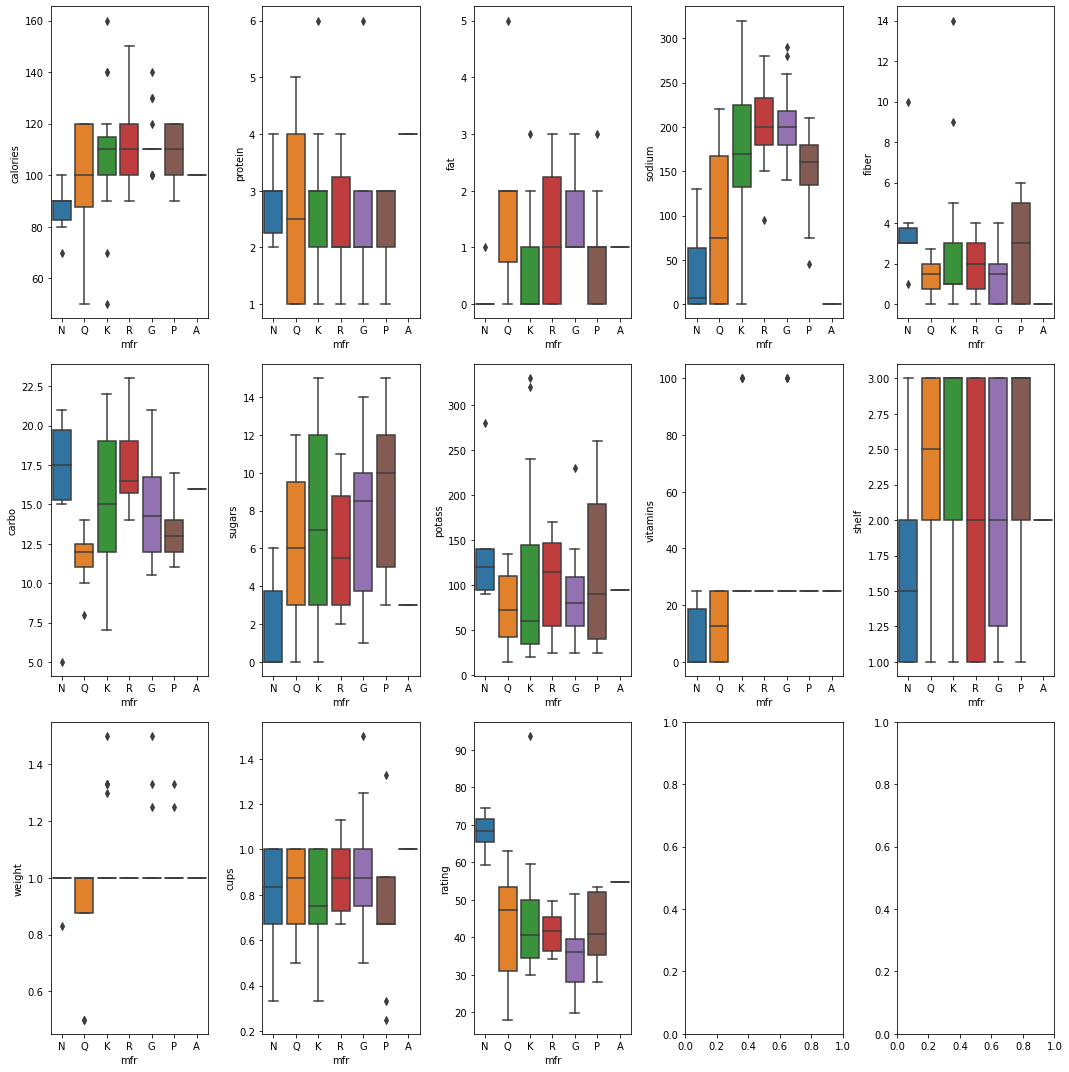

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=5,figsize=(15,15))
for name, ax in zip(names, axes.flatten()):
    sns.boxplot(y=name, x= CerealsData['mfr'], data=CerealsData, orient='v', ax=ax)    
plt.tight_layout()

* The cereals made from Nabisco contain lower sugar, fat, and sodium, so it has the highest average healthy rating. 

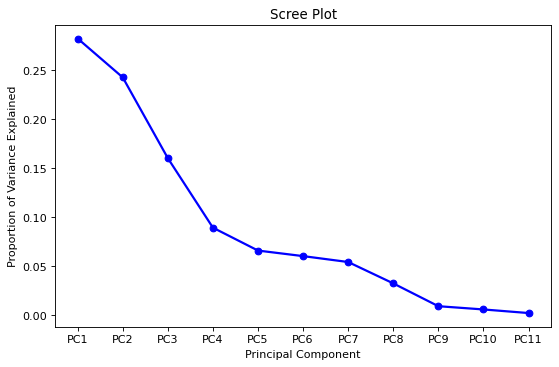

In [6]:
pcs = PCA()
NumericData = (NumericData-NumericData.mean())/NumericData.std()
NumericData = NumericData.drop(['rating','shelf'],axis=1)
pcs.fit(NumericData.dropna(axis=0))
pcsSummary_df = pd.DataFrame({'Standard Deviation': np.sqrt(pcs.explained_variance_),
                              'Proportion of Variance': pcs.explained_variance_ratio_,
                              'Cumulative Proportion': np.cumsum(pcs.explained_variance_ratio_)
                             })
pcsSummary_df = pcsSummary_df.transpose()
pcsSummary_df.columns=['PC{}'.format(i) for i in range(1, len(pcsSummary_df.columns) + 1)]
pcsSummary_df.round(4)

# Adjust the canvas
figure(figsize=(8, 5), dpi=80)

# Plot
plt.plot(pcsSummary_df.columns, pcs.explained_variance_ratio_, 'bo-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show('png')

* The plot above shows that most variety in cereals can be explained by top 4 principal components.

In [7]:
pcsComponents_df = pd.DataFrame(pcs.components_.transpose(),
                                columns=pcsSummary_df.columns,
                                index=NumericData.columns
                               )
pcsComponents_df.iloc[:,:4]

,PC1,PC2,PC3,PC4
calories,-0.005393,-0.582841,-0.077811,0.232019
protein,0.344818,0.008760,0.314950,0.448400
fat,0.188123,-0.265726,-0.298398,0.597136
sodium,-0.058244,-0.292765,0.340929,-0.187325
fiber,0.505328,0.155894,0.176851,-0.174662
carbo,-0.289086,-0.147221,0.515066,0.209974
sugars,0.061562,-0.370917,-0.490134,-0.352290
potass,0.532232,0.019896,0.130842,-0.063193
vitamins,-0.032692,-0.283631,0.333206,-0.336223
weight,0.247674,-0.484043,0.130002,-0.158274


* Principal component 1 is mainly made of protein,fiber, potass, and negative cups.
* Principal component 2 is mainly made of calories, sugars, and weight. It is intutive because sugars and calories have a positive relationship.
* Principal component 3 is mainly made of protein, sodium, carbo, and sugars. 
* Principal component 4 is mainly made of protein and fat. 

In [ ]:
# Create a list for appending SSE
distortions = []
# Find each SSE from clusters from 1 to 11
NumericData=NumericData.dropna(how='any')
for i in range(1, 11):
    km = KMeans(n_clusters=i,
                init='k-means++',
                n_init=10,
                max_iter=300,
                random_state=0
               )
    km.fit(NumericData)
    distortions.append(km.inertia_)

# Create Elbow Plot
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x=list(range(1,11)), 
                         y=distortions,
                         mode='lines+markers',
                         name='Distortion',
                         marker=dict(size=8,
                                     color='blue',
                                     symbol='circle',
                                     line=dict(width=2,
                                               color='DarkSlateGrey'))))
# Edit the layout
fig.update_layout(title='k-Means Elbow Plot',
                   xaxis_title='Cluster Count',
                   yaxis_title='Distortion = SSE')

fig.show('png')

C:\Users\momo8\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



In [ ]:
# Create clusterNumericData
clusters = linkage(pdist(NumericData, metric='euclidean'),method='average')
clusters = pd.DataFrame(clusters,
                         columns=['firm_i',
                          'firm_j',
                          'distance',
                          'no. of firms in clust.'
                             ],
                         index=['cluster %d' %(i+1) for i in range(clusters.shape[0])])
# Show table
#display(clusters)

# Adjust the canvas
figure(figsize=(12, 8), dpi=80)

# Making dendrogram and show
thing_dendr = dendrogram(clusters)
plt.tight_layout()
plt.ylabel('Euclidian Distance')
plt.axhline(y=5.5, color='r', linestyle='--')
plt.show('png')

* Through The Elbow Method, this data can be seperated into 5 main cereals clusters.